<a href="https://colab.research.google.com/github/edhillon7/Computer_Vision-/blob/main/lane_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

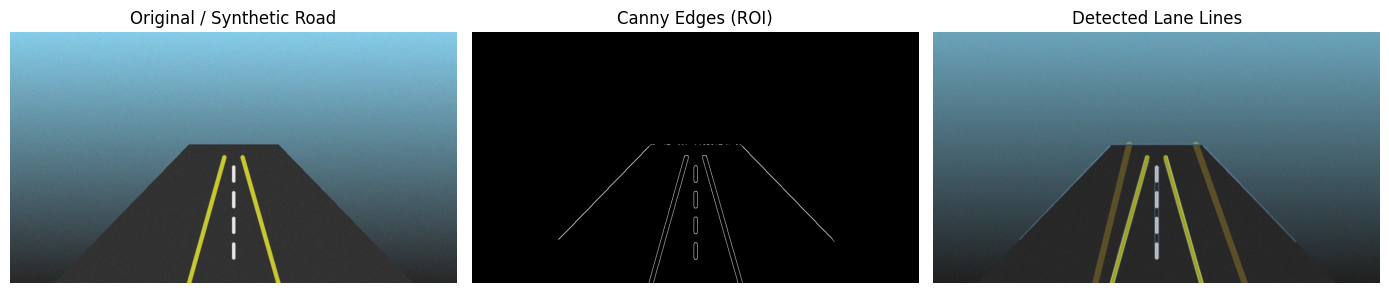

✅ Saved output as 'lane_detection_output.jpg'
Left lane (x1,y1,x2,y2): (348, 540, 421, 243)
Right lane (x1,y1,x2,y2): (669, 540, 564, 243)


In [32]:
# -*- coding: utf-8 -*-
"""
Clean Lane Detection (Hough Lines) Notebook
Author: Ekam Dhillon (cleaned)
Description:
 - Generates a synthetic road image with lane markings so the notebook runs without uploads
 - Or, optionally, you can upload a real road image in Colab by setting USE_UPLOAD=True
 - Performs Canny edge detection + ROI masking + HoughLinesP
 - Visualizes and saves the result
"""

# If running in Colab and dependencies are missing, uncomment below:
# !pip install --quiet opencv-python-headless matplotlib numpy

import cv2
import numpy as np
import matplotlib.pyplot as plt

def make_sample_road_image(width=960, height=540):
    """Create a synthetic road-like RGB image with perspective and lane markings."""
    img = np.zeros((height, width, 3), dtype=np.uint8)

    # create a simple sky-to-road gradient
    for y in range(height):
        t = y / height
        # top: light blue, bottom: dark asphalt
        r = int((1 - t) * 135 + t * 40)
        g = int((1 - t) * 206 + t * 40)
        b = int((1 - t) * 235 + t * 40)
        img[y, :] = (r, g, b)

    # draw road polygon (dark gray)
    road_color = (50, 50, 50)
    road_coords = np.array([[
        (int(width * 0.1), height),
        (int(width * 0.9), height),
        (int(width * 0.6), int(height * 0.45)),
        (int(width * 0.4), int(height * 0.45))
    ]], dtype=np.int32)
    cv2.fillPoly(img, road_coords, road_color)

    # draw dashed center lane (perspective)
    def draw_dashed_line(x1, y1, x2, y2, color, dash_len=30, gap_len=20, thickness=6):
        length = int(np.hypot(x2-x1, y2-y1))
        dx = (x2 - x1) / length
        dy = (y2 - y1) / length
        cur = 0
        while cur < length:
            x_start = int(x1 + dx * cur)
            y_start = int(y1 + dy * cur)
            seg = min(dash_len, length - cur)
            x_end = int(x1 + dx * (cur + seg))
            y_end = int(y1 + dy * (cur + seg))
            cv2.line(img, (x_start, y_start), (x_end, y_end), color, thickness, cv2.LINE_AA)
            cur += dash_len + gap_len

    # center dashed line (white)
    draw_dashed_line(int(width*0.5), int(height*0.9), int(width*0.5), int(height*0.5), (230,230,230), dash_len=30, gap_len=25, thickness=6)

    # left and right solid lane edges (yellow/white)
    cv2.line(img, (int(width*0.4), height), (int(width*0.48), int(height*0.5)), (200,200,50), 8, cv2.LINE_AA)
    cv2.line(img, (int(width*0.6), height), (int(width*0.52), int(height*0.5)), (200,200,50), 8, cv2.LINE_AA)

    # a little gaussian noise to make it realistic
    noise = (np.random.randn(*img.shape) * 6).astype(np.int16)
    noisy = np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8)
    return noisy

# Toggle to True to upload your own image in Colab
USE_UPLOAD = False

if USE_UPLOAD:
    from google.colab import files
    print("📸 Upload a road image (with lane markings).")
    uploaded = files.upload()
    fname = next(iter(uploaded.keys()))
    img_rgb = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    if img_rgb is None:
        raise ValueError("Failed to read uploaded file.")
else:
    img_rgb = make_sample_road_image()

# Keep a copy for overlays
orig = img_rgb.copy()

# 1. Convert to grayscale and blur
gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# 2. Canny edge detector (tweak thresholds for your images)
low_th, high_th = 50, 150
edges = cv2.Canny(blur, low_th, high_th)

# 3. Region of interest mask (polygon roughly covering the road)
h, w = edges.shape
mask = np.zeros_like(edges)
# polygon vertices (bottom-left, bottom-right, top-right, top-left)
roi = np.array([[
    (int(w * 0.05), h),
    (int(w * 0.95), h),
    (int(w * 0.6), int(h * 0.45)),
    (int(w * 0.4), int(h * 0.45))
]], dtype=np.int32)
cv2.fillPoly(mask, roi, 255)
masked_edges = cv2.bitwise_and(edges, mask)

# 4. Hough Line Transform (probabilistic)
rho = 2
theta = np.pi / 180
threshold = 60
min_line_len = 40
max_line_gap = 120

lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, minLineLength=min_line_len, maxLineGap=max_line_gap)

# 5. Draw lines (and optionally average/extrapolate to left & right lanes)
line_img = np.zeros_like(orig)

if lines is not None:
    # Optionally separate into left/right groups by slope
    left_lines = []
    right_lines = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        # avoid vertical / near-zero slope
        if x2 == x1:
            continue
        slope = (y2 - y1) / (x2 - x1)
        if abs(slope) < 0.3:
            # ignore near-horizontal lines
            continue
        if slope < 0:
            left_lines.append((x1, y1, x2, y2))
        else:
            right_lines.append((x1, y1, x2, y2))

    # helper to average lines and extrapolate
    def average_and_extrapolate(lines_group, y_min, y_max):
        if len(lines_group) == 0:
            return None
        xs = []
        ys = []
        for x1, y1, x2, y2 in lines_group:
            xs += [x1, x2]
            ys += [y1, y2]
        # fit line: x = m*y + c (we invert to avoid infinite slopes)
        m, c = np.polyfit(ys, xs, 1)  # fit x as function of y
        x_top = int(m * y_min + c)
        x_bottom = int(m * y_max + c)
        return (x_bottom, y_max, x_top, y_min)

    y_max = h
    y_min = int(h * 0.45)

    left_lane = average_and_extrapolate(left_lines, y_min, y_max)
    right_lane = average_and_extrapolate(right_lines, y_min, y_max)

    # draw the averaged/extrapolated lanes
    if left_lane is not None:
        x1, y1, x2, y2 = left_lane
        cv2.line(line_img, (x1, y1), (x2, y2), (255, 200, 0), 12, cv2.LINE_AA)
    if right_lane is not None:
        x1, y1, x2, y2 = right_lane
        cv2.line(line_img, (x1, y1), (x2, y2), (255, 200, 0), 12, cv2.LINE_AA)

    # draw original detected segments (thin) for debugging
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_img, (x1, y1), (x2, y2), (120, 180, 255), 2)

else:
    print("No Hough lines detected — try lowering the Hough threshold or adjusting Canny thresholds.")

# 6. Combine overlay with original
alpha = 0.8
combined = cv2.addWeighted(orig, alpha, line_img, 1 - alpha, 0)

# 7. Display results
plt.figure(figsize=(14, 7))
plt.subplot(1, 3, 1)
plt.title("Original / Synthetic Road")
plt.imshow(orig)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Canny Edges (ROI)")
plt.imshow(masked_edges, cmap='gray')
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Detected Lane Lines")
plt.imshow(combined)
plt.axis("off")

plt.tight_layout()
plt.show()

# 8. Save output image
output_name = "lane_detection_output.jpg"
# convert RGB to BGR for cv2.imwrite
cv2.imwrite(output_name, cv2.cvtColor(combined, cv2.COLOR_RGB2BGR))
print(f"✅ Saved output as '{output_name}'")

# Optional: print detected lane endpoints
if 'left_lane' in locals() and left_lane is not None:
    print("Left lane (x1,y1,x2,y2):", left_lane)
if 'right_lane' in locals() and right_lane is not None:
    print("Right lane (x1,y1,x2,y2):", right_lane)
